# ===============================================================================
* NOTEBOOK 1 : NETTOYAGE DES DONNÉES
* Projet : Modèle de prévision de l'occupation des stades
# ===============================================================================

In [76]:
import sys,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



# Configuration de l'affichage

In [77]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')



# 1. IMPORT DES DONNÉES

In [78]:
print("\n[1] IMPORT DES DONNÉES")
print("-"*80)

# Lecture du fichier CSV avec séparateur ;
df = pd.read_csv('../data/raw/ScrapeDataGlobal.csv', sep=';', encoding='utf-8')

print(f"✓ Fichier chargé avec succès")
print(f"  - Nombre de lignes : {df.shape[0]}")
print(f"  - Nombre de colonnes : {df.shape[1]}")
print(f"\nNom des colonnes :")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")


[1] IMPORT DES DONNÉES
--------------------------------------------------------------------------------
✓ Fichier chargé avec succès
  - Nombre de lignes : 363
  - Nombre de colonnes : 19

Nom des colonnes :
  1. ﻿Competition
  2. saison
  3. Stade
  4. Ville
  5. Capacite
  6. Equipe_Home
  7. Equipe_Away
  8. Score
  9. isDerby
  10. PhaseImportance
  11. is_important_match
  12. is_top_team_home
  13. affluence_moyenne
  14. date_Match
  15. heure_match
  16. prix_billet_moyen
  17. temperature
  18. Recette_Moyenne
  19. source_file


# 2. ANALYSE INITIALE

In [79]:
print("\n[2] ANALYSE INITIALE")
print("-"*80)
print("\n2.1 Aperçu des premières lignes :")
df.rename(columns=lambda x: x.encode('utf-8').decode('utf-8-sig').strip(), inplace=True)
print(df.head())

print("\n2.2 Informations sur les types de données :")
print(df.info())

print("\n2.3 Statistiques descriptives :")
print(df.describe())

print("\n2.4 Valeurs manquantes par colonne :")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage (%)': missing_pct
})
print(missing_df[missing_df['Valeurs manquantes'] > 0])

print("\n2.5 Distribution par compétition :")
print(df['Competition'].value_counts())


[2] ANALYSE INITIALE
--------------------------------------------------------------------------------

2.1 Aperçu des premières lignes :
  Competition     saison                         Stade       Ville  Capacite                         Equipe_Home          Equipe_Away  Score  isDerby  PhaseImportance  is_important_match  is_top_team_home  affluence_moyenne  date_Match heure_match  prix_billet_moyen  temperature  Recette_Moyenne                   source_file
0  Botola Pro  2019/2020               Stade Mohamed V  Casablanca     67000  Club Athletic Youssoufia Berrechid      Difaâ El Jadida  01:00    False                1               False             False              20000  10/10/2020       16:00                 60         20.3          1200000  botola_2019_2020_matches.csv
1  Botola Pro  2019/2020  Stade Municipale de Oued Zem    Oued Zem      8000                     Rapide Oued Zem       Ittihad Tanger  05:03    False                1               False             False    

# 3. NETTOYAGE DES TYPES DE DONNÉES

In [80]:
print("\n[3] NETTOYAGE DES TYPES DE DONNÉES")
print("-"*80)
# Copie du dataframe pour travailler
df_clean = df.copy()

# Conversion des colonnes numériques
colonnes_numeriques = ['Capacite', 'affluence_moyenne', 'prix_billet_moyen', 
                        'temperature', 'Recette_Moyenne']

for col in colonnes_numeriques:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print("✓ Colonnes numériques converties")

# Conversion des colonnes booléennes
colonnes_bool = ['isDerby', 'is_important_match', 'is_top_team_home']

for col in colonnes_bool:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(bool)

print("✓ Colonnes booléennes converties")

# Conversion de la date
if 'date_Match' in df_clean.columns:
    df_clean['date_Match'] = pd.to_datetime(df_clean['date_Match'], errors='coerce')
    print("✓ Colonne date convertie")

print(f"\nTypes de données après nettoyage :")
print(df_clean.dtypes)


[3] NETTOYAGE DES TYPES DE DONNÉES
--------------------------------------------------------------------------------
✓ Colonnes numériques converties
✓ Colonnes booléennes converties
✓ Colonne date convertie

Types de données après nettoyage :
Competition                   object
saison                        object
Stade                         object
Ville                         object
Capacite                       int64
Equipe_Home                   object
Equipe_Away                   object
Score                         object
isDerby                         bool
PhaseImportance                int64
is_important_match              bool
is_top_team_home                bool
affluence_moyenne              int64
date_Match            datetime64[ns]
heure_match                   object
prix_billet_moyen              int64
temperature                  float64
Recette_Moyenne                int64
source_file                   object
dtype: object


# 4. TRAITEMENT SPÉCIAL BOTOLA PRO 
 * DÉSAGRÉGATION : lors de la collecte des données, et précisemment la compétition de la "Botola Pro", on a collecté que l'affluence moyenne, c'est ce qu'on a trouvé, mais pour régulariser avec les autres, on procédera à la désagrégée.

In [81]:
print("\n[4] TRAITEMENT SPÉCIAL BOTOLA PRO")
print("-"*80)
# Identification des lignes Botola Pro
botola_mask = df_clean['Competition'] == 'Botola Pro'
nb_botola = botola_mask.sum()
print(f"✓ Lignes Botola Pro identifiées : {nb_botola}")

# Créer une colonne pour marquer le type d'affluence
df_clean['type_affluence'] = 'reelle'
df_clean.loc[botola_mask, 'type_affluence'] = 'moyenne'

print("\n4.1 Calcul des coefficients multiplicateurs pour Botola Pro")

# Sauvegarde de l'affluence moyenne originale
df_clean['affluence_moyenne_originale'] = df_clean['affluence_moyenne'].copy()

# Application des coefficients pour les lignes Botola Pro
for idx in df_clean[botola_mask].index:
    coeff = 1.0
    
    # Coefficient Derby (+20%)
    if df_clean.loc[idx, 'isDerby']:
        coeff += 0.20
    
    # Coefficient Phase Importante (+15%)
    if df_clean.loc[idx, 'PhaseImportance'] in ['Finale', 'Demi-finale', 'Quart de finale']:
        coeff += 0.15
    
    # Coefficient Match Important (+10%)
    if df_clean.loc[idx, 'is_important_match']:
        coeff += 0.10
    
    # Coefficient Top Team (+10%)
    if df_clean.loc[idx, 'is_top_team_home']:
        coeff += 0.10
    
    # Coefficient Heure du match (soirée +5%)
    if pd.notna(df_clean.loc[idx, 'heure_match']):
        heure = str(df_clean.loc[idx, 'heure_match'])
        if '19' in heure or '20' in heure or '21' in heure:
            coeff += 0.05
    
    # Coefficient Température favorable (+5% si entre 15 et 25°C)
    if pd.notna(df_clean.loc[idx, 'temperature']):
        temp = df_clean.loc[idx, 'temperature']
        if 15 <= temp <= 25:
            coeff += 0.05
    
    # Application du coefficient avec variation aléatoire légère (±5%)
    variation = np.random.uniform(0.95, 1.05)
    coeff_final = coeff * variation
    
    # Calcul de l'affluence ajustée
    affluence_base = df_clean.loc[idx, 'affluence_moyenne']
    df_clean.loc[idx, 'affluence_moyenne'] = affluence_base * coeff_final

print("✓ Affluence désagrégée pour Botola Pro")

# Statistiques avant/après pour Botola Pro
print("\n4.2 Comparaison avant/après désagrégation (Botola Pro) :")
print(f"Avant - Moyenne : {df_clean.loc[botola_mask, 'affluence_moyenne_originale'].mean():.0f}")
print(f"Avant - Std : {df_clean.loc[botola_mask, 'affluence_moyenne_originale'].std():.0f}")
print(f"Après - Moyenne : {df_clean.loc[botola_mask, 'affluence_moyenne'].mean():.0f}")
print(f"Après - Std : {df_clean.loc[botola_mask, 'affluence_moyenne'].std():.0f}")



[4] TRAITEMENT SPÉCIAL BOTOLA PRO
--------------------------------------------------------------------------------
✓ Lignes Botola Pro identifiées : 240

4.1 Calcul des coefficients multiplicateurs pour Botola Pro
✓ Affluence désagrégée pour Botola Pro

4.2 Comparaison avant/après désagrégation (Botola Pro) :
Avant - Moyenne : 9475
Avant - Std : 6315
Après - Moyenne : 10790
Après - Std : 7416


# 5. CRÉATION DE NOUVELLES VARIABLES

In [82]:
print("\n[5] CRÉATION DE NOUVELLES VARIABLES")
print("-"*80)
# Taux d'occupation
df_clean['taux_occupation'] = (df_clean['affluence_moyenne'] / df_clean['Capacite']) * 100
df_clean['taux_occupation'] = df_clean['taux_occupation'].clip(0, 100)
print("✓ Variable 'taux_occupation' créée")

# Variables temporelles
if 'date_Match' in df_clean.columns:
    df_clean['annee'] = df_clean['date_Match'].dt.year
    df_clean['mois'] = df_clean['date_Match'].dt.month
    df_clean['jour_semaine'] = df_clean['date_Match'].dt.dayofweek  # 0=Lundi, 6=Dimanche
    df_clean['est_weekend'] = df_clean['jour_semaine'].isin([5, 6]).astype(int)
    print("✓ Variables temporelles créées")

# Catégorie de capacité
df_clean['categorie_stade'] = pd.cut(df_clean['Capacite'], 
                                       bins=[0, 1200, 30000, 60000],
                                       labels=['Petit', 'Moyen', 'Grand'])
print("✓ Variable 'categorie_stade' créée")

# Interaction Derby x Top Team
df_clean['derby_top_team'] = (df_clean['isDerby'] & df_clean['is_top_team_home']).astype(int)
print("✓ Variable d'interaction créée")

print(f"\nNombre total de variables : {df_clean.shape[1]}")


[5] CRÉATION DE NOUVELLES VARIABLES
--------------------------------------------------------------------------------
✓ Variable 'taux_occupation' créée
✓ Variables temporelles créées
✓ Variable 'categorie_stade' créée
✓ Variable d'interaction créée

Nombre total de variables : 28


# 6. TRAITEMENT DES VALEURS MANQUANTES

In [83]:
print("\n[6] TRAITEMENT DES VALEURS MANQUANTES")
print("-"*80)
print("\n6.1 Valeurs manquantes avant traitement :")
missing_before = df_clean.isnull().sum()
print(missing_before[missing_before > 0])

# Imputation de la température par la médiane
if 'temperature' in df_clean.columns:
    median_temp = df_clean['temperature'].median()
    df_clean['temperature'].fillna(median_temp, inplace=True)
    print(f"✓ Température : imputée par la médiane ({median_temp}°C)")

# Imputation du prix du billet par la médiane par compétition
if 'prix_billet_moyen' in df_clean.columns:
    df_clean['prix_billet_moyen'] = df_clean.groupby('Competition')['prix_billet_moyen'].transform(
        lambda x: x.fillna(x.median())
    )
    print("✓ Prix billet : imputé par la médiane par compétition")

# Imputation de la recette moyenne
if 'Recette_Moyenne' in df_clean.columns:
    df_clean['Recette_Moyenne'].fillna(
        df_clean['affluence_moyenne'] * df_clean['prix_billet_moyen'], 
        inplace=True
    )
    print("✓ Recette moyenne : calculée si manquante")

print("\n6.2 Valeurs manquantes après traitement :")
missing_after = df_clean.isnull().sum()
print(missing_after[missing_after > 0])



[6] TRAITEMENT DES VALEURS MANQUANTES
--------------------------------------------------------------------------------

6.1 Valeurs manquantes avant traitement :
date_Match         98
temperature         4
annee              98
mois               98
jour_semaine       98
categorie_stade    81
dtype: int64
✓ Température : imputée par la médiane (20.4°C)
✓ Prix billet : imputé par la médiane par compétition
✓ Recette moyenne : calculée si manquante

6.2 Valeurs manquantes après traitement :
date_Match         98
annee              98
mois               98
jour_semaine       98
categorie_stade    81
dtype: int64


# 7. DÉTECTION ET TRAITEMENT DES OUTLIERS

In [84]:
print("\n[7] DÉTECTION DES OUTLIERS")
print("-"*80)

def detect_outliers_iqr(data, column):
    """Détecte les outliers avec la méthode IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Détection des outliers pour l'affluence
outliers_affluence, lb_aff, ub_aff = detect_outliers_iqr(df_clean, 'affluence_moyenne')
print(f"\n7.1 Outliers affluence :")
print(f"  - Nombre : {len(outliers_affluence)}")
print(f"  - Limites : [{lb_aff:.0f}, {ub_aff:.0f}]")

# Détection des outliers pour le taux d'occupation
outliers_taux, lb_taux, ub_taux = detect_outliers_iqr(df_clean, 'taux_occupation')
print(f"\n7.2 Outliers taux d'occupation :")
print(f"  - Nombre : {len(outliers_taux)}")
print(f"  - Limites : [{lb_taux:.1f}%, {ub_taux:.1f}%]")

# Marquage des outliers (sans suppression)
df_clean['is_outlier_affluence'] = df_clean.index.isin(outliers_affluence.index)
df_clean['is_outlier_taux'] = df_clean.index.isin(outliers_taux.index)

print("\n✓ Outliers marqués (non supprimés pour analyse ultérieure)")


[7] DÉTECTION DES OUTLIERS
--------------------------------------------------------------------------------

7.1 Outliers affluence :
  - Nombre : 8
  - Limites : [-15512, 44521]

7.2 Outliers taux d'occupation :
  - Nombre : 0
  - Limites : [-21.6%, 119.3%]

✓ Outliers marqués (non supprimés pour analyse ultérieure)


# 8. STATISTIQUES FINALES

In [85]:
print("\n[8] STATISTIQUES FINALES")
print("-"*80)

print("\n8.1 Dimensions finales :")
print(f"  - Lignes : {df_clean.shape[0]}")
print(f"  - Colonnes : {df_clean.shape[1]}")

print("\n8.2 Statistiques de la variable cible (affluence) :")
print(df_clean['affluence_moyenne'].describe())

print("\n8.3 Statistiques du taux d'occupation :")
print(df_clean['taux_occupation'].describe())

print("\n8.4 Distribution par compétition :")
print(df_clean.groupby('Competition').agg({
    'affluence_moyenne': ['count', 'mean', 'std'],
    'taux_occupation': 'mean'
}).round(2))



[8] STATISTIQUES FINALES
--------------------------------------------------------------------------------

8.1 Dimensions finales :
  - Lignes : 363
  - Colonnes : 30

8.2 Statistiques de la variable cible (affluence) :
count      363.000000
mean     15025.278764
std      11973.905569
min          0.000000
25%       7000.726425
50%       9796.000000
75%      22008.978257
max      64178.000000
Name: affluence_moyenne, dtype: float64

8.3 Statistiques du taux d'occupation :
count    363.000000
mean      47.344456
std       23.893227
min        0.000000
25%       31.260316
50%       47.649470
75%       66.474755
max       99.740000
Name: taux_occupation, dtype: float64

8.4 Distribution par compétition :
                    affluence_moyenne                     taux_occupation
                                count      mean       std            mean
Competition                                                              
Botola Pro                        240  10789.78   7415.85         

# 9. VISUALISATIONS


[9] GÉNÉRATION DES VISUALISATIONS
--------------------------------------------------------------------------------
✓ Visualisations sauvegardées : ../visualisation/nettoyage/cleaning_visualizations.png


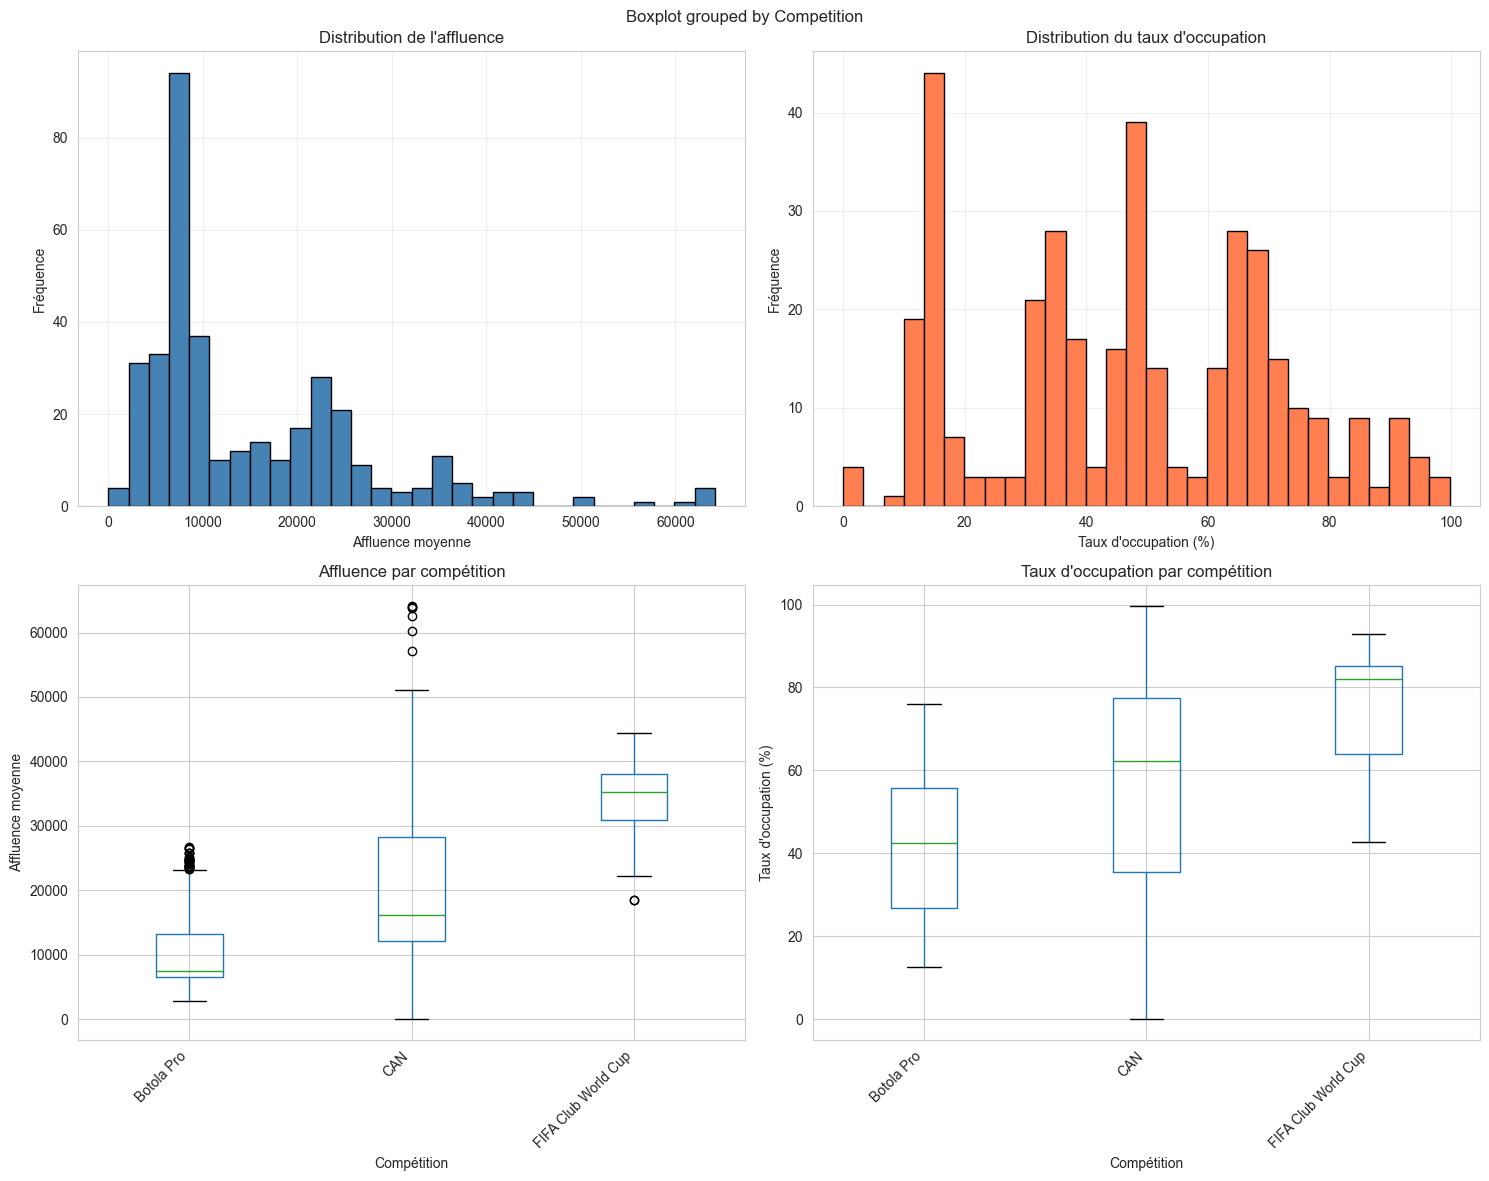

In [86]:
print("\n[9] GÉNÉRATION DES VISUALISATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution de l'affluence
axes[0, 0].hist(df_clean['affluence_moyenne'], bins=30, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Affluence moyenne')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution de l\'affluence')
axes[0, 0].grid(True, alpha=0.3)

# Distribution du taux d'occupation
axes[0, 1].hist(df_clean['taux_occupation'], bins=30, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Taux d\'occupation (%)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution du taux d\'occupation')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot affluence par compétition
df_clean.boxplot(column='affluence_moyenne', by='Competition', ax=axes[1, 0])
axes[1, 0].set_xlabel('Compétition')
axes[1, 0].set_ylabel('Affluence moyenne')
axes[1, 0].set_title('Affluence par compétition')
axes[1, 0].tick_params(axis='x', rotation=45)
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# Taux d'occupation par compétition
df_clean.boxplot(column='taux_occupation', by='Competition', ax=axes[1, 1])
axes[1, 1].set_xlabel('Compétition')
axes[1, 1].set_ylabel('Taux d\'occupation (%)')
axes[1, 1].set_title('Taux d\'occupation par compétition')
axes[1, 1].tick_params(axis='x', rotation=45)
plt.sca(axes[1, 1])
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
output_path = "../visualisation/nettoyage"
os.makedirs(output_path, exist_ok=True)

plt.savefig(f"{output_path}/cleaning_visualizations.png", dpi=300, bbox_inches='tight')
print(f"✓ Visualisations sauvegardées : {output_path}/cleaning_visualizations.png")
plt.show()


# 10. EXPORT DES DONNÉES NETTOYÉES

In [ ]:
print("\n[10] EXPORT DES DONNÉES NETTOYÉES")
print("-"*80)

# Création du dossier si nécessaire
import os
os.makedirs('../data/processed/', exist_ok=True)

# Export en CSV
output_file = '../data/processed/data_cleaned.csv'
df_clean.to_csv(output_file, index=False, encoding='utf-8')
print(f"✓ Données nettoyées exportées : {output_file}")

# Export d'un rapport de nettoyage
rapport = f"""
RAPPORT DE NETTOYAGE DES DONNÉES
Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================

1. DONNÉES INITIALES
   - Lignes : {df.shape[0]}
   - Colonnes : {df.shape[1]}

2. DONNÉES NETTOYÉES
   - Lignes : {df_clean.shape[0]}
   - Colonnes : {df_clean.shape[1]}
   - Lignes supprimées : {df.shape[0] - df_clean.shape[0]}

3. TRAITEMENT BOTOLA PRO
   - Lignes concernées : {nb_botola}
   - Affluence désagrégée avec coefficients multiplicateurs
   - Variance introduite : ±5% aléatoire

4. VARIABLES CRÉÉES
   - taux_occupation (%)
   - Variables temporelles (annee, mois, jour_semaine, est_weekend)
   - categorie_stade (Petit/Moyen/Grand)
   - derby_top_team (interaction)
   - Marqueurs outliers

5. VALEURS MANQUANTES TRAITÉES
   - Température : imputée par médiane
   - Prix billet : imputé par médiane par compétition
   - Recette : calculée si manquante

6. OUTLIERS DÉTECTÉS
   - Affluence : {len(outliers_affluence)} outliers
   - Taux occupation : {len(outliers_taux)} outliers
   - Marqués mais non supprimés

7. STATISTIQUES CLÉS
   - Affluence moyenne : {df_clean['affluence_moyenne'].mean():.0f} ± {df_clean['affluence_moyenne'].std():.0f}
   - Taux occupation moyen : {df_clean['taux_occupation'].mean():.1f}%
   - Capacité moyenne : {df_clean['Capacite'].mean():.0f}

Fichier de sortie : {output_file}
"""

with open('../rapport/rapport_nettoyage.txt', 'w', encoding='utf-8') as f:
    f.write(rapport)

print("✓ Rapport de nettoyage créé : ../rapport/rapport_nettoyage.txt")

print("\n" + "="*80) 
print("NETTOYAGE TERMINÉ AVEC SUCCÈS !")
print("="*80)
print(f"\nFichiers générés :")
print(f"  1. data/processed/data_cleaned.csv")
print(f"  2. data/processed/rapport_nettoyage.txt")
print(f"  3. data/processed/cleaning_visualizations.png")
print("\nProchaine étape : Notebook 2 - EDA (Analyse Exploratoire des Données)")


[10] EXPORT DES DONNÉES NETTOYÉES
--------------------------------------------------------------------------------
✓ Données nettoyées exportées : ../data/processed/data_cleaned.csv
✓ Rapport de nettoyage créé : ../data/raw/rapport_nettoyage.txt

NETTOYAGE TERMINÉ AVEC SUCCÈS !

Fichiers générés :
  1. data/processed/data_cleaned.csv
  2. data/processed/rapport_nettoyage.txt
  3. data/processed/cleaning_visualizations.png

Prochaine étape : Notebook 2 - EDA (Analyse Exploratoire des Données)
